**Author:** Dan Shea  
**Date:** 2019.10.15  
**Description:**
#### Weighted Gene Co-expression Network Analysis
This library implements the analytical methods described in "WGCNA: an R package for weighted correlation network analysis" by Langfelder and Horvath, 2008 (doi: 10.1186/1471-2105-9-559). Given a the gene expression data for a sample population (where a population size of $n$ is recommended to be $n \ge 15$), a network is first constructed using the correlation of expression between genes. Here, genes are the set that comprises the vertices of the graph $G$. We may then construct an $n \times m$ matrix $X$ such that $X_{ij}$ is the $i^{th}$ gene of the $j^{th}$ sample. The correlation (signed $cor(x_{i}, x_{j})$ or unsigned $|cor(x_{i}, x_{j})|$) of the expression values is then used as the weighted link between the two genes.

Given that $s_{ij} = |cor(x_{i},x_{j})|$ we can construct a co-expression network defined by edges $a_{ij}$ that satisfy either a hard threshold $\tau$, where $a_{ij} = 1$ _iff_ $s_{ij} \ge \tau$ and $a_{ij} = 0$ _iff_ $s_{ij} \lt \tau$, or a soft threshold $\beta$, where $a_{ij} = s_{ij}^{\beta}$.

If trait based data is also applied (_e.g._ - phenotypic, GO, KEGG pathway, _etc._) each node may be assigned a trait-based significance measure $GS_{i} = |cor(x_{i},T)|$, where $T$ is a vector with $m$ components that correspond to the columns of $X$. That is to say, each sample in the population has an assigned trait value in $T$.

Once the graph / network has been constructed, we may then cluster nodes into _modules_, where a module is defined as a set of highly interconnected nodes. The modules (_i.e._ - a set of sub-networks) may then be ranked by a suitable metric (_e.g._ - The mean connectivity of each node in the module, or the mean $\overline{GS}$ computed from the $GS_{i}$ of each node in the module.) 

In [1]:
import networkx as nx
import nxviz
import numpy as np
import scipy.stats as spstats
import re
import random
import os
import os.path
import sys
from collections import OrderedDict

In [2]:
def load_data(filename, sep='\t'):
    '''
    load_data(filename) loads the data defined in filename.
    returns a dictionary with the gene names as keys and a numpy array of expression values as the value.
    '''
    try:
        with open(filename, 'r') as fh:
            D = OrderedDict()
            for line in fh:
                line = line.strip()
                data = line.split(sep)
                key = data.pop(0)
                D[key] = np.array([float(x) for x in data])
            return D
    except FileNotFoundError as e:
        sys.stderr.write('{} cannot be opened for reading.\nPlease ensure the file exists and/or has the correct permissions.'.format(filename))
        sys.exit(1)

In [3]:
testdict = load_data('testdata.tsv')

In [4]:
# Let's make our own data
testdict = OrderedDict()
nsamples=30
fixed_data = np.array([random.random() for i in range(30)])
for i in range(100):
    if i % 2 == 0:
        testdict[f'gene{i}'] = np.array([random.random() for i in range(30)]) * fixed_data
    elif i % 3 == 0:
        testdict[f'gene{i}'] = np.array([random.random() for i in range(30)]) + fixed_data
    else:
        testdict[f'gene{i}'] = np.array([random.random() for i in range(30)])

In [5]:
def compute_correlation(data):
    rows = list(data.keys())
    n = len(rows)
    m = len(data[rows[0]])
    C = np.matrix(np.reshape(np.ones(n*n), (n, n)))
    i=0
    for rowi in rows:
        j = i + 1
        for rowj in rows[j:]:
            #print('Comparing {}:{} to {}:{}'.format(rowi,i,rowj,j), flush=True)
            if i == j:
                cor = 0
            else:
                cor = spstats.pearsonr(data[rowi], data[rowj])[0]
            C[i,j] = cor
            C[j,i] = cor
            j += 1
        i += 1
    return C

In [6]:
corr = compute_correlation(testdict)

In [7]:
# Because we don't compare any nodes with themselves, their correlation coefficients are 1.0.
# (Set from the initialization of the matrix as all 1 values)
# This is fine, because calculating the correlation of anything to itself would yield a coefficient of 1.0.
corr

matrix([[ 1.        ,  0.03744514,  0.45534824, ..., -0.03871343,
          0.25509014,  0.37684372],
        [ 0.03744514,  1.        ,  0.07605661, ..., -0.31266228,
         -0.03322342, -0.1733785 ],
        [ 0.45534824,  0.07605661,  1.        , ..., -0.02067622,
          0.46012479,  0.48605918],
        ...,
        [-0.03871343, -0.31266228, -0.02067622, ...,  1.        ,
          0.09837293,  0.13343374],
        [ 0.25509014, -0.03322342,  0.46012479, ...,  0.09837293,
          1.        ,  0.50645004],
        [ 0.37684372, -0.1733785 ,  0.48605918, ...,  0.13343374,
          0.50645004,  1.        ]])

We have constructed the matrix that represents the correlation (Pearson's correlation coefficient) for all ${\langle}x_{i},x_{j}{\rangle}$ in the data set. Next, we want to construct the adjacency matrix by applying weights. Consider that in a typical adjacency matrix, we have a symmetric matrix with binary values _i.e._ – $A = [a_{ij}]$ and $a_{ij} \in \{0,1\}$ We have essentially already construct such a matrix and applied the following transform $a_{ij} = cor(x_{i},x_{j}) \equiv W = A \cdot C$

However, this alone is not the weighted adjacency matrix $W$. We  apply a monotonic function that maps from $\mathcal{R} \in [0,1] \rightarrow [0,1]$. This function $f(s_{ij})$ may either be a hard thresholding, such as a step-function using some threshold $\tau$ such that $f(s_{ij}) = 0: s_{ij} < \tau, 1: s_{ij} \ge \tau$, or we may apply soft thresholding , such as a power function $f(s_{ij}) = s_{ij}^{\beta}$ where $\mathcal{I} \equiv \{0,1,\dots,n\}$ and $\beta \in \mathcal{I}$.

Here, we will make use of a power function $f(s_{ij}) = s_{ij}^{4}$ for starters and change $\beta$.  
__NOTE:__ As $\beta$ increases it begins to approximate a step function making use of $\tau = 0.8$

Rather than apply two functions separately, we can simply perform the power step when we compute the correlation. For pedagogical purposes, I have re-written the function below.

In [8]:
def compute_weighted_adjacency(data, beta=4):
    rows = list(data.keys())
    n = len(rows)
    m = len(data[rows[0]])
    W = np.matrix(np.reshape(np.ones(n*n), (n, n)))
    i=0
    for rowi in rows:
        j = i + 1
        for rowj in rows[j:]:
            #print('Comparing {}:{} to {}:{}'.format(rowi,i,rowj,j), flush=True)
            if i == j:
                wcor = 0
            else:
                wcor = (spstats.pearsonr(data[rowi], data[rowj])[0])**4
            W[i,j] = wcor
            W[j,i] = wcor
            j += 1
        i += 1
    return W

In [9]:
weighted_adjacency = compute_weighted_adjacency(testdict)

In [10]:
weighted_adjacency

matrix([[1.00000000e+00, 1.96599191e-06, 4.29907137e-02, ...,
         2.24618998e-06, 4.23423222e-03, 2.01671770e-02],
        [1.96599191e-06, 1.00000000e+00, 3.34616952e-05, ...,
         9.55656803e-03, 1.21836536e-06, 9.03609882e-04],
        [4.29907137e-02, 3.34616952e-05, 1.00000000e+00, ...,
         1.82761399e-07, 4.48231668e-02, 5.58157305e-02],
        ...,
        [2.24618998e-06, 9.55656803e-03, 1.82761399e-07, ...,
         1.00000000e+00, 9.36488504e-05, 3.17002458e-04],
        [4.23423222e-03, 1.21836536e-06, 4.48231668e-02, ...,
         9.36488504e-05, 1.00000000e+00, 6.57879625e-02],
        [2.01671770e-02, 9.03609882e-04, 5.58157305e-02, ...,
         3.17002458e-04, 6.57879625e-02, 1.00000000e+00]])

The Topology Overlay Matrix (TOM) is computed using the formula defined in Hierarchical organization of modularity in metabolic networks (Ravasz et al., 2002).

$$TOM_{ij} = \frac{l_{ij}+a_{ij}}{min(k_{i},k_{j})+1-a_{ij}}$$

$$DistTOM_{ij} = 1 - TOM_{ij}$$

Where:  
$$l_{ij} = \sum_{u{\ne}i,j}a_{iu}a_{uj}$$  
$$k_{i} = \sum_{u{\ne}i}a_{iu}$$  
$$k_{j} = \sum_{u{\ne}j}a_{uj}$$

In [11]:
def compute_tom(weighted_adjacency_matrix):
    # Initialize the TOM to zeros
    TOM = np.matrix(np.reshape(np.ones(weighted_adjacency_matrix.size), weighted_adjacency_matrix.shape))
    for i in range(weighted_adjacency_matrix.shape[0]):
        for j in range(weighted_adjacency_matrix.shape[1]):
            if i == j:
                TOM[i,j] = 1.0
                TOM[j,i] = 1.0
            else:
                ki = np.sum(weighted_adjacency_matrix[i, np.arange(weighted_adjacency_matrix[i,:].size) != j])
                kj = np.sum(weighted_adjacency_matrix[np.arange(weighted_adjacency_matrix[:,j].size) != i, j])
                l = np.sum(weighted_adjacency_matrix[i, np.arange(weighted_adjacency_matrix[i,:].size) != j] * weighted_adjacency_matrix[np.arange(weighted_adjacency_matrix[:,j].size) != i, j])
                numerator = l + weighted_adjacency_matrix[i, j]
                denominator = min(ki, kj) + (1 - weighted_adjacency_matrix[i,j])
                val = numerator / denominator
                TOM[i,j] = val
                TOM[j,i] = val
    return TOM

def distance_tom(TOM):
    return 1 - TOM

In [12]:
tom = compute_tom(weighted_adjacency)

In [13]:
tom

matrix([[1.        , 0.44234341, 0.04054446, ..., 0.06143358, 0.01094773,
         0.02099755],
        [0.44234341, 1.        , 0.4403549 , ..., 0.00587698, 0.02556272,
         0.02814686],
        [0.04054446, 0.4403549 , 1.        , ..., 0.00287494, 0.0280784 ,
         0.06128351],
        ...,
        [0.06143358, 0.00587698, 0.00287494, ..., 1.        , 0.44648687,
         0.03235723],
        [0.01094773, 0.02556272, 0.0280784 , ..., 0.44648687, 1.        ,
         0.33288221],
        [0.02099755, 0.02814686, 0.06128351, ..., 0.03235723, 0.33288221,
         1.        ]])

#### Visualizing a weighted network
Here, we will make use of `networkx` and the `nxviz` packages to construct a visual representation of the network.

In [18]:
# define a graph G
G = nx.Graph()

In [19]:
# add in the nodes of the network
for node in testdict.keys():
    G.add_node(node)
# loop through our weighted adjacency matrix and construct weighted edges between nodes
nodenames = list(testdict.keys())
tau = 0.2
for i in range(weighted_adjacency.shape[0]):
    jstart = i+1
    for j in range(jstart, weighted_adjacency.shape[1]):
        if i == j:
            pass
        else:
            if weighted_adjacency[i,j] >= tau:
                G.add_edge(nodenames[i], nodenames[j], weight=weighted_adjacency[i,j], module=tom[i,j])
            

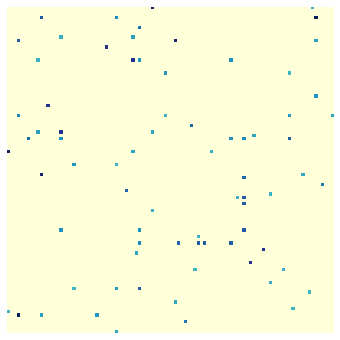

In [20]:
matrixplot = nxviz.MatrixPlot(G, edge_width='weight')
matrixplot.draw()

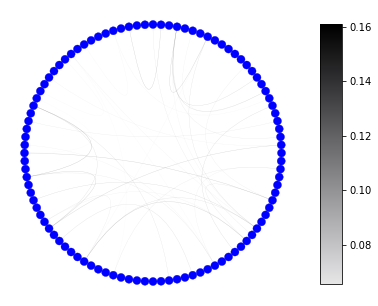

In [21]:
circos_plot = nxviz.CircosPlot(G, edge_width='weight', edge_color='module')
circos_plot.draw()